# FD002 World Model v3 (Phase 5 Residual) Diagnostics

This notebook is a **minimal, end-to-end FD002 pipeline** for the `WorldModelUniversalV3` model from `fd002_world_phase5_universal_v3_residual`:

- Data loading & feature engineering (with residual features)
- Model loading from checkpoint
- Test inference (EOL + HI + Trajectory)
- HI & RUL trajectories for 10 degraded engines
- Simple diagnostics (RMSE, NASA, histograms, scatter)

**Key design:** This notebook is self-contained and does NOT depend on `run_experiments.py` or the `diagnostics.py` stack. All control flow is explicit in the notebook cells.

**Model:** World Model v3 with:
- Residual/Digital-Twin features (464 features)
- UniversalEncoderV2 (d_model=96, multi-scale CNN + Transformer)
- Three heads: Trajectory, EOL, HI
- Horizon: 40 cycles


In [1]:
%matplotlib inline
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Force inline backend to override Agg from diagnostics.py
import matplotlib
matplotlib.use('module://matplotlib_inline.backend_inline')
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from pathlib import Path

# Repo imports
import sys
sys.path.insert(0, '..')

from src.data_loading import load_cmapps_subset
from src.additional_features import (
    create_physical_features,
    create_all_features,
    FeatureConfig,
    TemporalFeatureConfig,
    PhysicsFeatureConfig,
    ResidualFeatureConfig,
)
from src.feature_safety import remove_rul_leakage
from src.eol_full_lstm import build_test_sequences_from_df
from src.metrics import compute_eol_errors_and_nasa, nasa_phm_score_single
from src.models.world_model import WorldModelUniversalV3
from src.analysis.inference import load_model_from_experiment

# Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)


Using device: cpu


In [2]:
# Load FD002 train/test
dataset_name = "FD002"
df_train, df_test, y_test_true = load_cmapps_subset(
    dataset_name,
    max_rul=None,
    clip_train=False,
    clip_test=True,
)

print(f"Train: {len(df_train)} rows, {df_train['UnitNumber'].nunique()} engines")
print(f"Test: {len(df_test)} rows, {df_test['UnitNumber'].nunique()} engines")
print(f"Test RUL file: {len(y_test_true)} values")

# Feature engineering (Phase 5 with Residual Features)
# Same as fd002_world_phase5_universal_v3_residual
physics_config = PhysicsFeatureConfig(
    use_core=True,
    use_extended=False,
    use_residuals=True,  # Enable residual features
    use_temporal_on_physics=False,
    residual=ResidualFeatureConfig(
        enabled=True,
        mode="per_engine",
        baseline_len=30,
        include_original=True,
    ),
)
feature_config = FeatureConfig(
    add_physical_core=True,
    add_temporal_features=True,
    temporal=TemporalFeatureConfig(
        base_cols=None,
        short_windows=(5, 10),
        long_windows=(30,),
        add_rolling_mean=True,
        add_rolling_std=False,
        add_trend=True,
        add_delta=True,
        delta_lags=(5, 10),
    ),
)

df_train_fe = create_physical_features(df_train.copy(), physics_config, "UnitNumber", "TimeInCycles")
df_train_fe = create_all_features(df_train_fe, "UnitNumber", "TimeInCycles", feature_config, inplace=False)

df_test_fe = create_physical_features(df_test.copy(), physics_config, "UnitNumber", "TimeInCycles")
df_test_fe = create_all_features(df_test_fe, "UnitNumber", "TimeInCycles", feature_config, inplace=False)

# Build feature columns
feature_cols = [
    c for c in df_train_fe.columns
    if c not in ["UnitNumber", "TimeInCycles", "RUL", "RUL_raw", "MaxTime", "ConditionID"]
]
feature_cols, _ = remove_rul_leakage(feature_cols)
print(f"Num features: {len(feature_cols)}")
print(f"Expected: 464 features (base + residual)")


[ConditionID] Found 7 unique (S1_r, S2_r, S3_r) combos in TRAIN.
[ConditionID] Train ConditionIDs: [0 1 2 3 4 5 6]
[ConditionID] Test  ConditionIDs: [0 1 2 3 4 5 6]
Train: 53759 rows, 260 engines
Test: 33991 rows, 259 engines
Test RUL file: 259 values
Num features: 464
Expected: 464 features (base + residual)


In [3]:
# Sequence building parameters (same as fd002_world_phase5_universal_v3_residual)
past_len = 30
max_rul = 125
horizon = 40  # World Model v3 horizon

# Build test sequences (EOL windows only) - same as EOL models
X_test, unit_ids_test, cond_ids_test = build_test_sequences_from_df(
    df_test_fe,
    feature_cols=feature_cols,
    past_len=past_len,
    unit_col="UnitNumber",
    cycle_col="TimeInCycles",
)

print(f"Test: X={X_test.shape}, units={unit_ids_test.shape}, conds={cond_ids_test.shape}")
print(f"Past len: {past_len}, Horizon: {horizon}, Max RUL: {max_rul}")


[build_test_sequences_from_df] Summary
Num test units: 259
Using past_len=30
Num feature cols requested: 464
Num feature cols available: 464
X shape: torch.Size([259, 30, 464]), unit_ids shape: torch.Size([259]), cond_ids shape: torch.Size([259])
ConditionIDs: [0, 1, 2, 3, 4, 5, 6]
Test: X=torch.Size([259, 30, 464]), units=torch.Size([259]), conds=torch.Size([259])
Past len: 30, Horizon: 40, Max RUL: 125


In [4]:
# Condition-wise feature scaling (fit on train, transform test)
# Same as training pipeline
scaler_dict = {}

# Get all condition IDs from train data
all_cond_ids_train = df_train_fe["ConditionID"].unique()
all_cond_ids_test = df_test_fe["ConditionID"].unique()
all_cond_ids = np.unique(np.concatenate([all_cond_ids_train, all_cond_ids_test]))

X_test_np = X_test.numpy()

# Fit scalers on train data (per condition)
for cond in all_cond_ids:
    cond = int(cond)
    df_train_cond = df_train_fe[df_train_fe["ConditionID"] == cond]
    
    if len(df_train_cond) == 0:
        continue
    
    scaler = StandardScaler()
    # Fit on train features for this condition
    train_feats_flat = df_train_cond[feature_cols].values.astype(np.float32)
    scaler.fit(train_feats_flat)
    scaler_dict[cond] = scaler

print(f"Fitted scalers for {len(scaler_dict)} conditions: {sorted(scaler_dict.keys())}")

# Transform test data (per condition)
X_test_scaled = np.empty_like(X_test_np)
for cond in all_cond_ids:
    cond = int(cond)
    test_mask_cond = (cond_ids_test.numpy() == cond)
    
    if test_mask_cond.any() and cond in scaler_dict:
        scaler = scaler_dict[cond]
        X_test_scaled[test_mask_cond] = scaler.transform(
            X_test_np[test_mask_cond].reshape(-1, X_test_np.shape[-1])
        ).reshape(-1, past_len, len(feature_cols))

# Convert to tensors and move to device
X_test_t = torch.from_numpy(X_test_scaled).float().to(device)
cond_test_t = cond_ids_test.to(device)

print(f"Test sequences ready: {X_test_t.shape}")


Fitted scalers for 7 conditions: [0, 1, 2, 3, 4, 5, 6]
Test sequences ready: torch.Size([259, 30, 464])


In [5]:
# Load World Model v3 from checkpoint
experiment_name = "fd002_world_phase5_universal_v3_residual"
results_base = Path("../results")
experiment_dir = results_base / dataset_name.lower() / experiment_name

print(f"Loading model from experiment: {experiment_name}")
print(f"Experiment directory: {experiment_dir}")

# Check if experiment directory exists
if not experiment_dir.exists():
    raise FileNotFoundError(
        f"Experiment directory not found: {experiment_dir}\n"
        f"Please ensure the experiment has been trained first using:\n"
        f"  python run_experiments.py --experiments {experiment_name}"
    )

# Use load_model_from_experiment helper (expects experiment_dir Path, not experiment_name)
model, config = load_model_from_experiment(
    experiment_dir=experiment_dir,  # Pass Path object, not experiment_name
    device=device,
    input_dim=len(feature_cols),  # Provide input_dim explicitly
)
model.eval()

# Extract config values for reference
num_conditions = config.get("num_conditions", 7)  # FD002 has 7 conditions
d_model = config.get("d_model", 96)
horizon = config.get("horizon", 40)

print(f"✅ Model loaded successfully!")
print(f"  Input dim: {len(feature_cols)}")
print(f"  Num conditions: {num_conditions}")
print(f"  d_model: {d_model}")
print(f"  Horizon: {horizon}")

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")


Loading model from experiment: fd002_world_phase5_universal_v3_residual
Experiment directory: ..\results\fd002\fd002_world_phase5_universal_v3_residual
Loading model from ..\results\fd002\fd002_world_phase5_universal_v3_residual\world_model_v3_best.pt
Detected world-model v3 experiment: fd002_world_phase5_universal_v3_residual
  model_type=world_model_universal_v3, encoder_type=world_model_universal_v3
Inferred num_conditions=7 from checkpoint (encoder.cond_emb)
Using provided input_dim=464
Inferred num_conditions=7 and cond_emb_dim=4 from WorldModel v3 checkpoint
  Successfully loaded world model v3 checkpoint (strict=True)
✅ Model loaded successfully!
  Input dim: 464
  Num conditions: 7
  d_model: 96
  Horizon: 40
  Total parameters: 916,303
  Trainable parameters: 916,303


In [6]:
# Test inference with World Model v3
# IMPORTANT: For EOL inference, use horizon=1 (not the full horizon=40)
# This matches the diagnostics.py implementation
model.eval()
print(f"Using model type: {type(model).__name__}")
with torch.no_grad():
    outputs = model(
        encoder_inputs=X_test_t,
        decoder_targets=None,
        teacher_forcing_ratio=0.0,
        horizon=1,  # For EOL inference, we only need horizon=1 (not horizon=40)
        cond_ids=cond_test_t if num_conditions > 1 else None,
    )

# Extract predictions (handle both V3 dict and V2 tuple)
if isinstance(outputs, dict):
    # V3 Output
    rul_pred_test = outputs["eol"]  # (N, 1)
    hi_last_test = outputs.get("hi", None)
    hi_seq_test = outputs["traj"]   # (N, 1, 1)
elif isinstance(outputs, tuple):
    # V2 Output (traj, eol)
    hi_seq_test, rul_pred_test = outputs
    hi_last_test = None
else:
    raise ValueError(f"Unexpected output type: {type(outputs)}")

# Convert to numpy and apply capping
rul_pred_np = rul_pred_test.cpu().numpy().flatten()
rul_pred_np = np.clip(rul_pred_np, 0.0, max_rul)

# Build true RUL per engine
# CRITICAL: unit_ids_test and y_test_true must be aligned
unit_ids_test_np = unit_ids_test.numpy()

# Verify alignment
if len(unit_ids_test_np) != len(y_test_true):
    raise ValueError(f"Mismatch: {len(unit_ids_test_np)} test sequences but {len(y_test_true)} true RUL values.")

y_true_eol = np.minimum(y_test_true, max_rul)  # Cap true RUL

# Debug: Print statistics to verify predictions are reasonable
print(f"  Debug: RUL prediction statistics")
print(f"  Predicted RUL: min={rul_pred_np.min():.2f}, max={rul_pred_np.max():.2f}, mean={rul_pred_np.mean():.2f}, std={rul_pred_np.std():.2f}")
print(f"  True RUL:      min={y_true_eol.min():.2f}, max={y_true_eol.max():.2f}, mean={y_true_eol.mean():.2f}, std={y_true_eol.std():.2f}")
print(f"  Number of engines: {len(unit_ids_test_np)}")

# Compute basic EOL metrics
eol_metrics = compute_eol_errors_and_nasa(y_true_eol, rul_pred_np, max_rul=max_rul)

print("=" * 60)
print(f"Test Metrics (EOL-based) - {type(model).__name__}")
print("=" * 60)
print(f"RMSE: {eol_metrics['rmse']:.2f} cycles")
print(f"MAE:  {eol_metrics['mae']:.2f} cycles")
print(f"Bias: {eol_metrics['bias']:.2f} cycles")
print(f"R²:   {eol_metrics['r2']:.4f}")
print(f"NASA Score (sum):  {eol_metrics['nasa_sum']:.2f}")
print(f"NASA Score (mean): {eol_metrics['nasa_mean']:.4f}")
print("=" * 60)


Using model type: WorldModelUniversalV3
  Debug: RUL prediction statistics
  Predicted RUL: min=46.87, max=125.00, mean=96.47, std=34.50
  True RUL:      min=6.00, max=125.00, mean=73.69, std=42.94
  Number of engines: 259
Test Metrics (EOL-based) - WorldModelUniversalV3
RMSE: 58.41 cycles
MAE:  46.49 cycles
Bias: 22.78 cycles
R²:   -0.8505
NASA Score (sum):  2864631.19
NASA Score (mean): 11060.3521


In [7]:
# Basic Evaluation Plots

# Plot diagnostics
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Error histogram
errors = rul_pred_np - y_true_eol
axes[0].hist(errors, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero error')
axes[0].set_xlabel('Error (pred - true) [cycles]')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'Error Histogram (mean={errors.mean():.2f}, std={errors.std():.2f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Scatter: true vs pred
axes[1].scatter(y_true_eol, rul_pred_np, alpha=0.5, s=20)
axes[1].plot([0, max_rul], [0, max_rul], 'r--', linewidth=2, label='Perfect prediction')
axes[1].set_xlabel('True RUL [cycles]')
axes[1].set_ylabel('Predicted RUL [cycles]')
axes[1].set_title(f'True vs Predicted RUL - {type(model).__name__}')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_aspect('equal', adjustable='box')

plt.suptitle(f'Basic Evaluation Plots - {type(model).__name__}', fontsize=14, y=1.02)
plt.tight_layout()


In [8]:
# Extended Metrics: Per-Condition Analysis
print("=" * 80)
print("Extended Metrics: Per-Condition Analysis")
print("=" * 80)

# Compute per-condition metrics
condition_metrics = {}
cond_ids_test_np = cond_ids_test.numpy()

for cond_id in sorted(np.unique(cond_ids_test_np)):
    cond_id = int(cond_id)
    cond_mask = (cond_ids_test_np == cond_id)
    
    if not cond_mask.any():
        continue
    
    y_true_cond = y_true_eol[cond_mask]
    rul_pred_cond = rul_pred_np[cond_mask]
    
    # Compute metrics for this condition
    cond_metrics = compute_eol_errors_and_nasa(y_true_cond, rul_pred_cond, max_rul=max_rul)
    condition_metrics[cond_id] = cond_metrics
    
    print(f"  Condition {cond_id}:")
    print(f"  Engines: {cond_mask.sum()}")
    print(f"  RMSE: {cond_metrics['rmse']:.2f} cycles")
    print(f"  MAE:  {cond_metrics['mae']:.2f} cycles")
    print(f"  Bias: {cond_metrics['bias']:.2f} cycles")
    print(f"  R²:   {cond_metrics['r2']:.4f}")
    print(f"  NASA Mean: {cond_metrics['nasa_mean']:.4f}")

# Save per-condition metrics to JSON
condition_metrics_json = {}
for cond_id, metrics in condition_metrics.items():
    condition_metrics_json[str(cond_id)] = {
        k: float(v) if isinstance(v, (np.integer, np.floating)) else v.tolist() if isinstance(v, np.ndarray) else v
        for k, v in metrics.items()
    }

print("=" * 80)


Extended Metrics: Per-Condition Analysis
  Condition 0:
  Engines: 37
  RMSE: 46.61 cycles
  MAE:  43.39 cycles
  Bias: -15.03 cycles
  R²:   -0.0945
  NASA Mean: 89.9412
  Condition 1:
  Engines: 61
  RMSE: 45.09 cycles
  MAE:  39.83 cycles
  Bias: -19.52 cycles
  R²:   -0.1956
  NASA Mean: 77.7857
  Condition 2:
  Engines: 40
  RMSE: 63.09 cycles
  MAE:  49.05 cycles
  Bias: 49.05 cycles
  R²:   -1.5282
  NASA Mean: 14263.8749
  Condition 3:
  Engines: 41
  RMSE: 63.72 cycles
  MAE:  51.60 cycles
  Bias: 42.86 cycles
  R²:   -1.2589
  NASA Mean: 14181.6994
  Condition 4:
  Engines: 49
  RMSE: 65.96 cycles
  MAE:  48.35 cycles
  Bias: 48.35 cycles
  R²:   -1.1608
  NASA Mean: 22570.9159
  Condition 5:
  Engines: 17
  RMSE: 65.55 cycles
  MAE:  46.35 cycles
  Bias: 46.35 cycles
  R²:   -1.0004
  NASA Mean: 16483.3096
  Condition 6:
  Engines: 14
  RMSE: 69.36 cycles
  MAE:  55.11 cycles
  Bias: 55.11 cycles
  R²:   -1.7262
  NASA Mean: 22740.1877


In [9]:
# Additional Evaluation Plots

# 1. Per-Condition Scatter Plots
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, cond_id in enumerate(sorted(condition_metrics.keys())):
    if idx >= len(axes):
        break
    
    ax = axes[idx]
    cond_id = int(cond_id)
    cond_mask = (cond_ids_test_np == cond_id)
    
    y_true_cond = y_true_eol[cond_mask]
    rul_pred_cond = rul_pred_np[cond_mask]
    
    ax.scatter(y_true_cond, rul_pred_cond, alpha=0.6, s=30)
    ax.plot([0, max_rul], [0, max_rul], 'r--', linewidth=2, label='Perfect prediction')
    ax.set_xlabel('True RUL [cycles]')
    ax.set_ylabel('Predicted RUL [cycles]')
    ax.set_title(f'Condition {cond_id}\nRMSE: {condition_metrics[cond_id]["rmse"]:.2f}, R²: {condition_metrics[cond_id]["r2"]:.4f}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal', adjustable='box')

# Hide unused subplots
for idx in range(len(condition_metrics), len(axes)):
    axes[idx].axis('off')

plt.suptitle('True vs Predicted RUL - Per Condition', fontsize=14, y=0.98)
plt.subplots_adjust(left=0.05, right=0.98, top=0.94, bottom=0.08, hspace=0.4, wspace=0.3)
plt.show()  # Display plot

# 2. Per-Condition Error Distributions
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, cond_id in enumerate(sorted(condition_metrics.keys())):
    if idx >= len(axes):
        break
    
    ax = axes[idx]
    cond_id = int(cond_id)
    cond_mask = (cond_ids_test_np == cond_id)
    
    errors_cond = rul_pred_np[cond_mask] - y_true_eol[cond_mask]
    
    ax.hist(errors_cond, bins=30, edgecolor='black', alpha=0.7)
    ax.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero error')
    ax.axvline(errors_cond.mean(), color='orange', linestyle='-', linewidth=2, label=f'Mean: {errors_cond.mean():.2f}')
    ax.set_xlabel('Error (pred - true) [cycles]')
    ax.set_ylabel('Frequency')
    ax.set_title(f'Condition {cond_id}\nMean: {errors_cond.mean():.2f}, Std: {errors_cond.std():.2f}')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Hide unused subplots
for idx in range(len(condition_metrics), len(axes)):
    axes[idx].axis('off')

plt.suptitle('Error Distribution - Per Condition', fontsize=14, y=0.98)
plt.subplots_adjust(left=0.05, right=0.98, top=0.94, bottom=0.08, hspace=0.4, wspace=0.3)
plt.show()  # Display plot

# 3. Per-Condition Metrics Comparison (Bar Charts)
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

cond_ids_sorted = sorted(condition_metrics.keys())
cond_labels = [f'Cond {c}' for c in cond_ids_sorted]

# RMSE
ax = axes[0]
rmse_values = [condition_metrics[c]['rmse'] for c in cond_ids_sorted]
ax.bar(cond_labels, rmse_values, alpha=0.7, color='steelblue')
ax.set_ylabel('RMSE [cycles]')
ax.set_title('RMSE per Condition')
ax.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(rmse_values):
    ax.text(i, v, f'{v:.1f}', ha='center', va='bottom')

# MAE
ax = axes[1]
mae_values = [condition_metrics[c]['mae'] for c in cond_ids_sorted]
ax.bar(cond_labels, mae_values, alpha=0.7, color='coral')
ax.set_ylabel('MAE [cycles]')
ax.set_title('MAE per Condition')
ax.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(mae_values):
    ax.text(i, v, f'{v:.1f}', ha='center', va='bottom')

# Bias
ax = axes[2]
bias_values = [condition_metrics[c]['bias'] for c in cond_ids_sorted]
colors = ['green' if abs(b) < 5 else 'red' for b in bias_values]
ax.bar(cond_labels, bias_values, alpha=0.7, color=colors)
ax.axhline(0, color='black', linestyle='-', linewidth=1)
ax.set_ylabel('Bias [cycles]')
ax.set_title('Bias per Condition')
ax.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(bias_values):
    ax.text(i, v, f'{v:.1f}', ha='center', va='bottom' if v >= 0 else 'top')

# R²
ax = axes[3]
r2_values = [condition_metrics[c]['r2'] for c in cond_ids_sorted]
ax.bar(cond_labels, r2_values, alpha=0.7, color='purple')
ax.set_ylabel('R²')
ax.set_title('R² per Condition')
ax.set_ylim([0, 1])
ax.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(r2_values):
    ax.text(i, v, f'{v:.3f}', ha='center', va='bottom')

# NASA Mean
ax = axes[4]
nasa_values = [condition_metrics[c]['nasa_mean'] for c in cond_ids_sorted]
ax.bar(cond_labels, nasa_values, alpha=0.7, color='orange')
ax.set_ylabel('NASA Score (mean)')
ax.set_title('NASA Score per Condition')
ax.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(nasa_values):
    ax.text(i, v, f'{v:.1f}', ha='center', va='bottom')

# Number of engines per condition
ax = axes[5]
n_engines = [np.sum(cond_ids_test_np == c) for c in cond_ids_sorted]
ax.bar(cond_labels, n_engines, alpha=0.7, color='gray')
ax.set_ylabel('Number of Engines')
ax.set_title('Test Engines per Condition')
ax.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(n_engines):
    ax.text(i, v, f'{v}', ha='center', va='bottom')

plt.suptitle('Metrics Comparison - Per Condition', fontsize=14, y=0.98)
plt.subplots_adjust(left=0.05, right=0.98, top=0.94, bottom=0.08, hspace=0.4, wspace=0.3)
plt.show()  # Display plot

# 4. Error vs True RUL Analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Error vs True RUL scatter
errors = rul_pred_np - y_true_eol
axes[0].scatter(y_true_eol, errors, alpha=0.5, s=20)
axes[0].axhline(0, color='red', linestyle='--', linewidth=2, label='Zero error')
axes[0].set_xlabel('True RUL [cycles]')
axes[0].set_ylabel('Error (pred - true) [cycles]')
axes[0].set_title('Error vs True RUL')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Binned error analysis
bins = np.linspace(0, max_rul, 11)
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_errors = []
bin_errors_std = []
for i in range(len(bins) - 1):
    mask = (y_true_eol >= bins[i]) & (y_true_eol < bins[i + 1])
    if mask.any():
        bin_errors.append(errors[mask].mean())
        bin_errors_std.append(errors[mask].std())
    else:
        bin_errors.append(0)
        bin_errors_std.append(0)

axes[1].errorbar(bin_centers, bin_errors, yerr=bin_errors_std, 
                 marker='o', linestyle='-', linewidth=2, markersize=8, capsize=5)
axes[1].axhline(0, color='red', linestyle='--', linewidth=2, label='Zero error')
axes[1].set_xlabel('True RUL [cycles] (binned)')
axes[1].set_ylabel('Mean Error [cycles]')
axes[1].set_title('Mean Error vs True RUL (Binned)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('Error Analysis vs True RUL', fontsize=14, y=0.98)
plt.subplots_adjust(left=0.05, right=0.98, top=0.94, bottom=0.08, hspace=0.4, wspace=0.3)
plt.show()  # Display plot

plt.show()  # Display last plot
print("✅ Extended evaluation plots generated")


C:\Users\rober\AppData\Local\Temp\ipykernel_32616\1001962528.py:33: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()  # Display plot
C:\Users\rober\AppData\Local\Temp\ipykernel_32616\1001962528.py:64: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()  # Display plot
C:\Users\rober\AppData\Local\Temp\ipykernel_32616\1001962528.py:138: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()  # Display plot
C:\Users\rober\AppData\Local\Temp\ipykernel_32616\1001962528.py:178: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()  # Display plot
C:\Users\rober\AppData\Local\Temp\ipykernel_32616\1001962528.py:180: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()  # Display last plot


✅ Extended evaluation plots generated


HI Trajectories for 5 Degraded Engines
Selected degraded engines: [211, 44, 177, 11, 7]


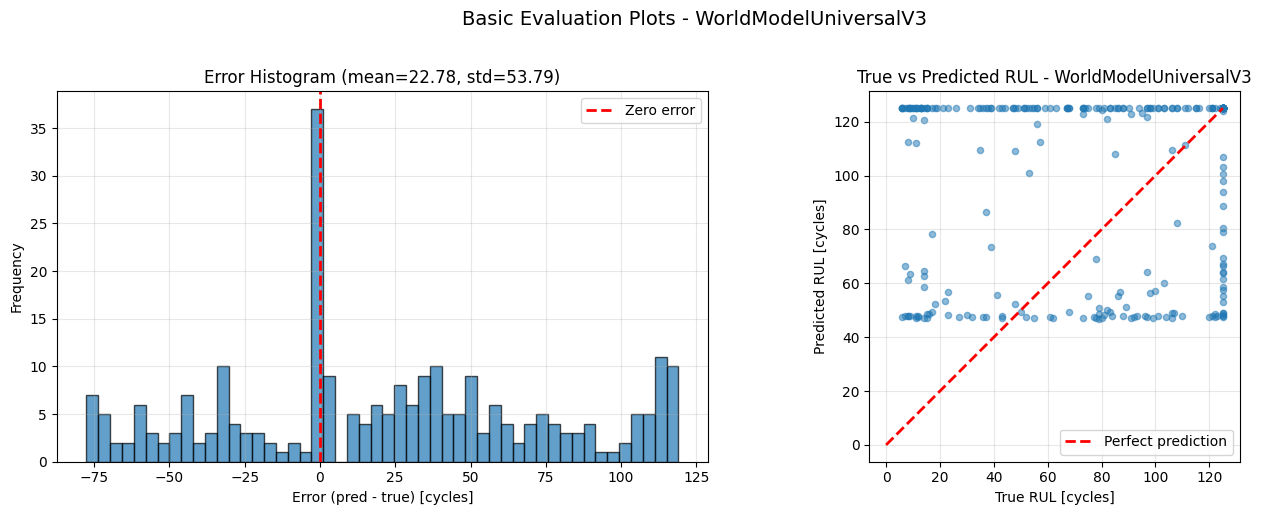

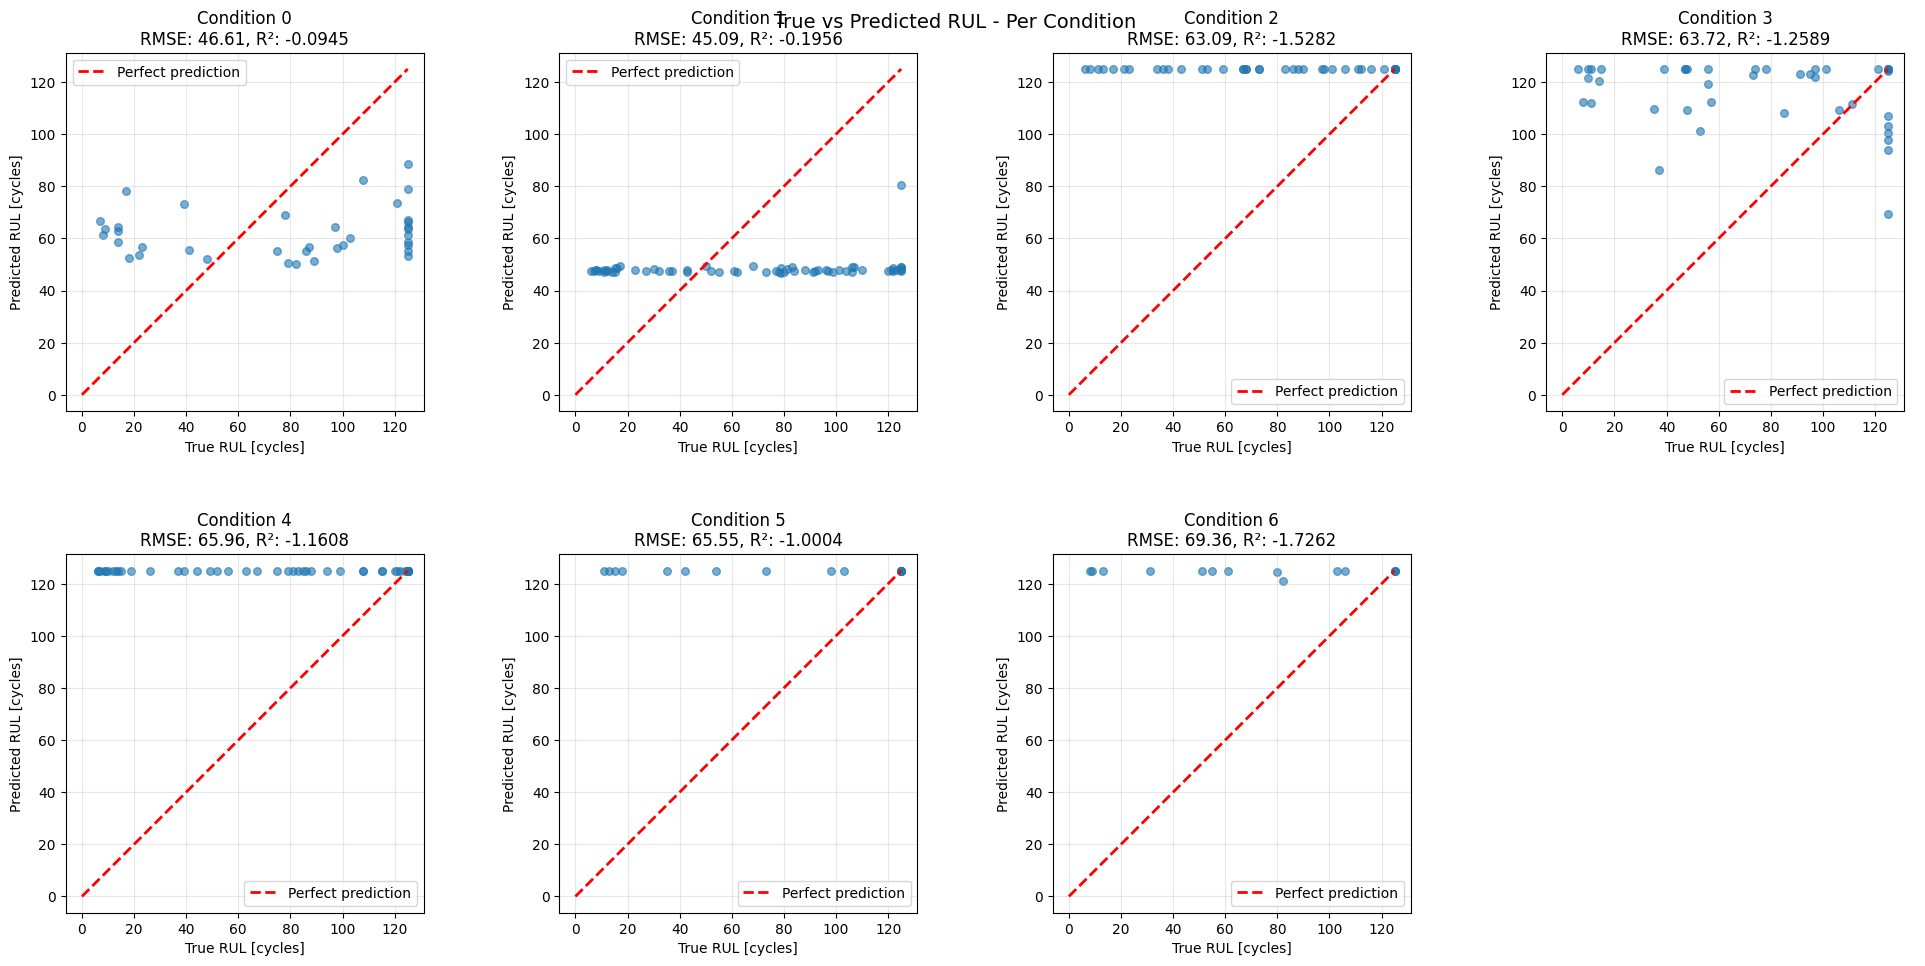

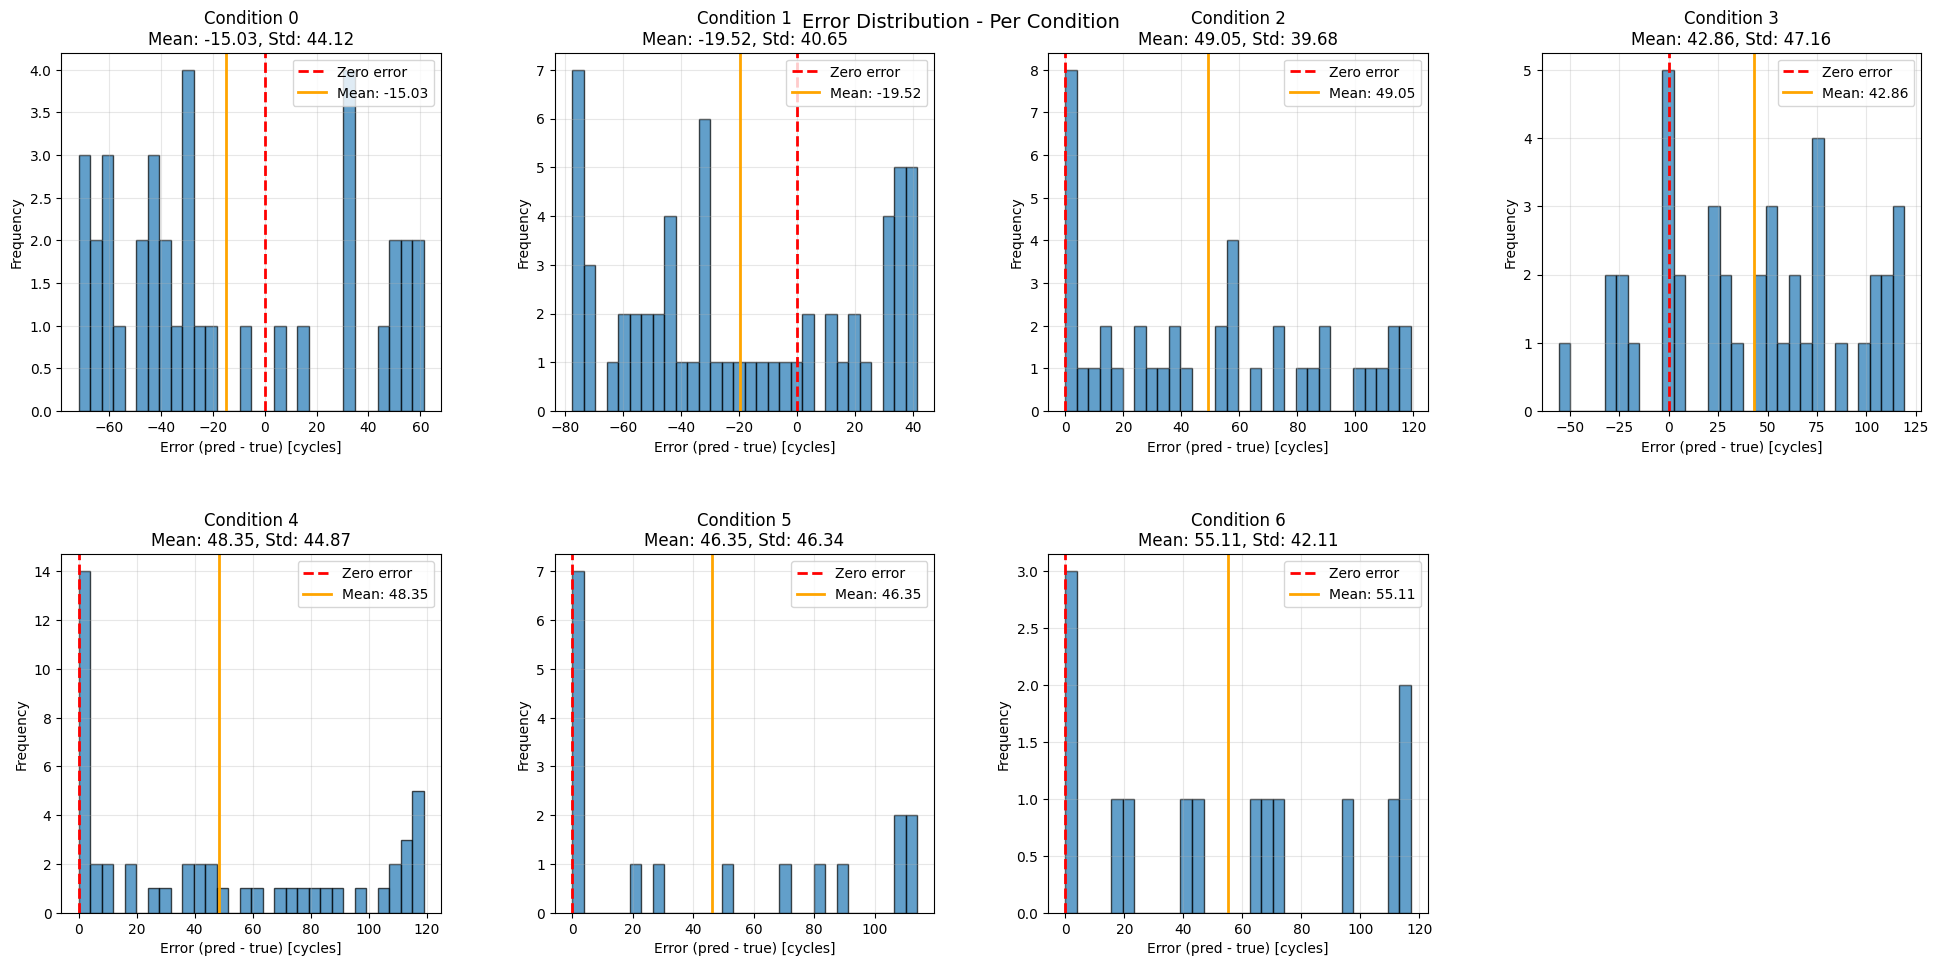

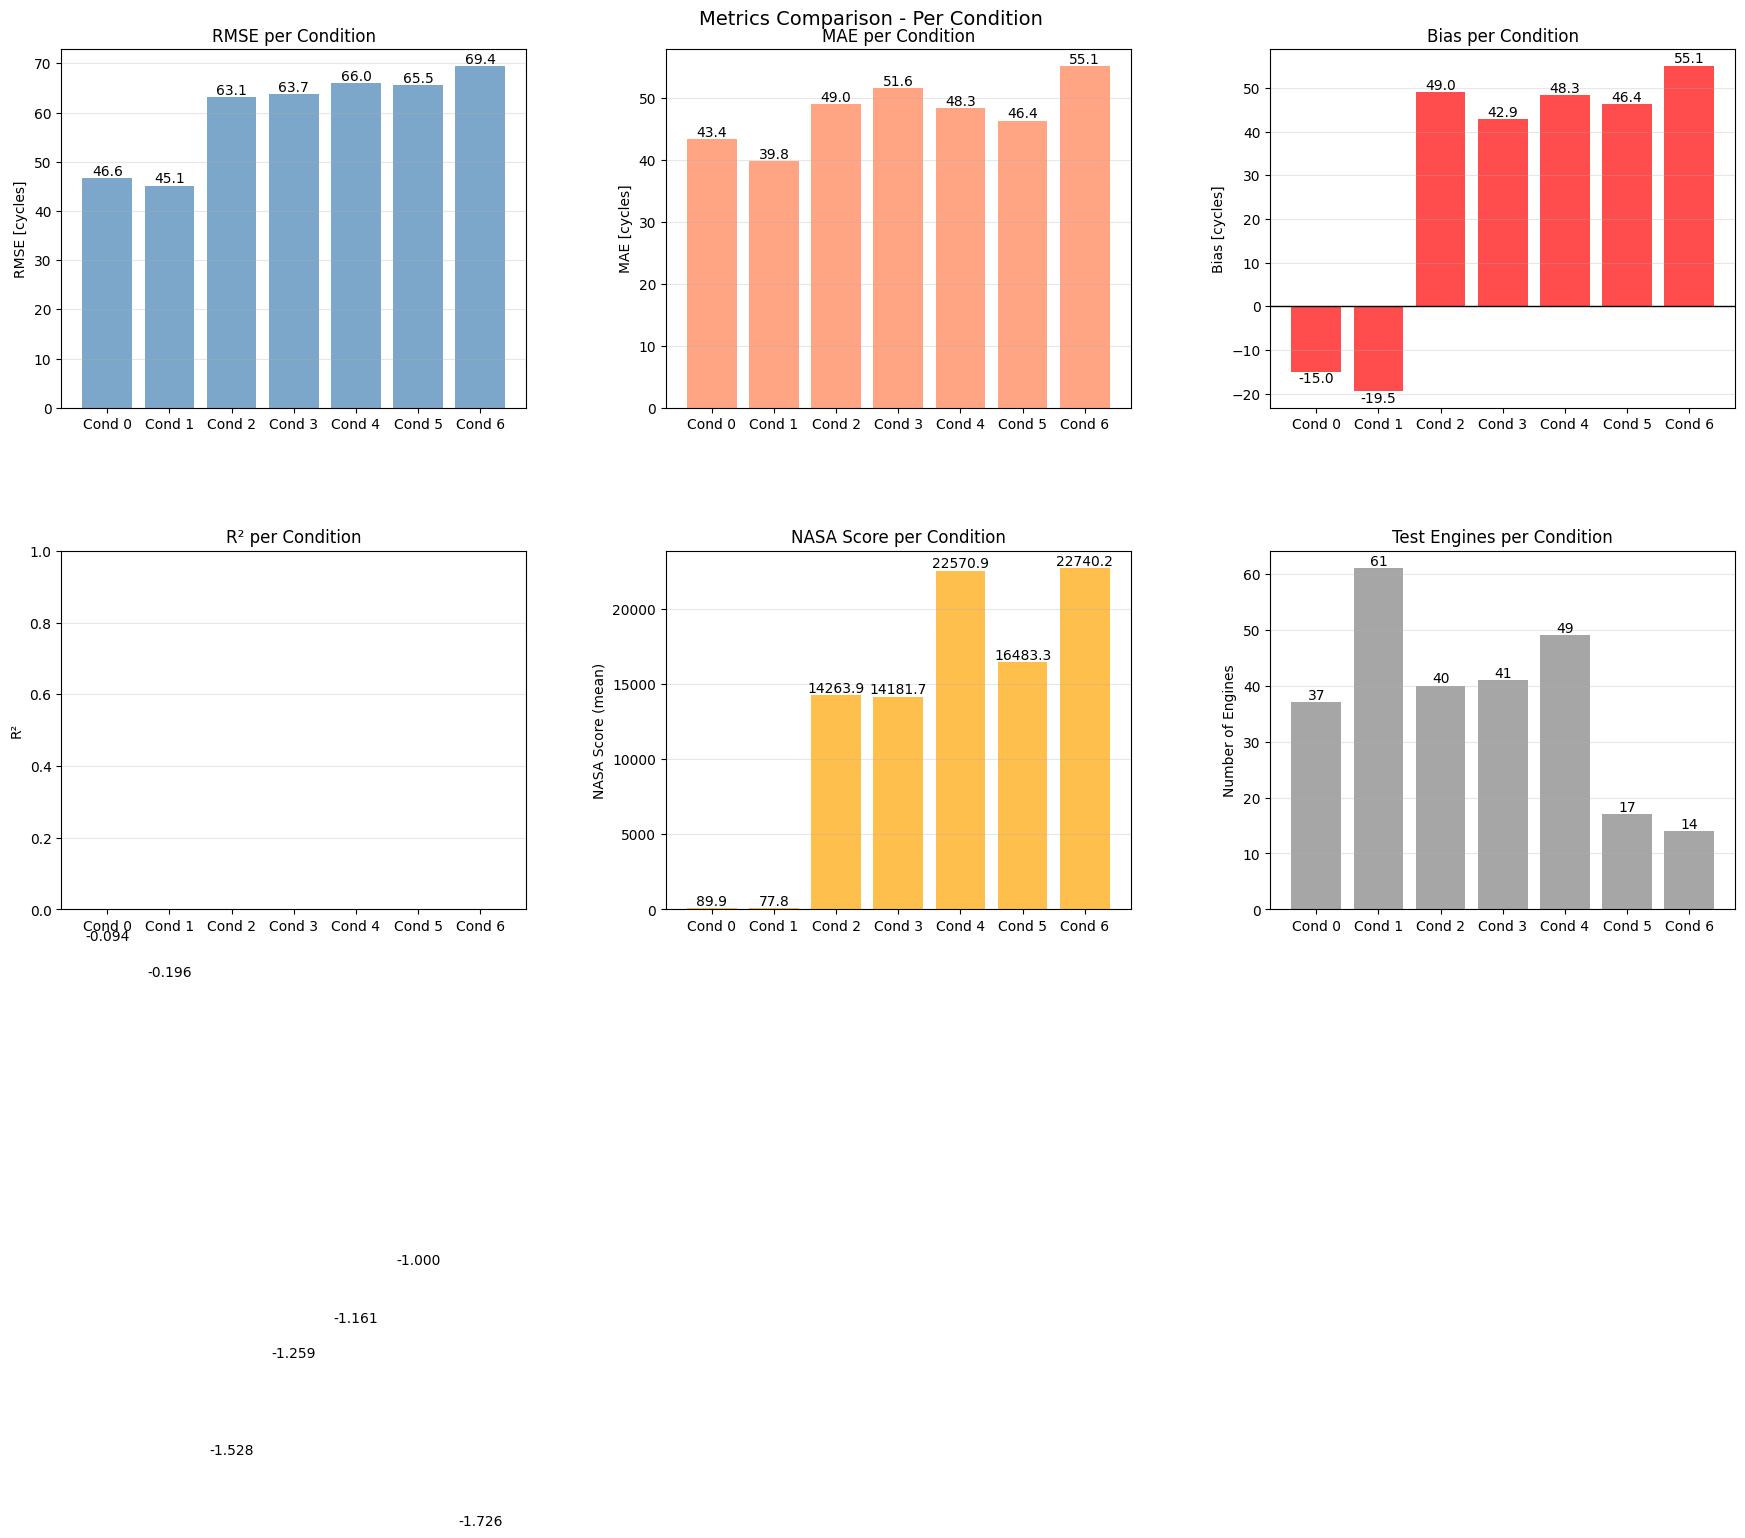

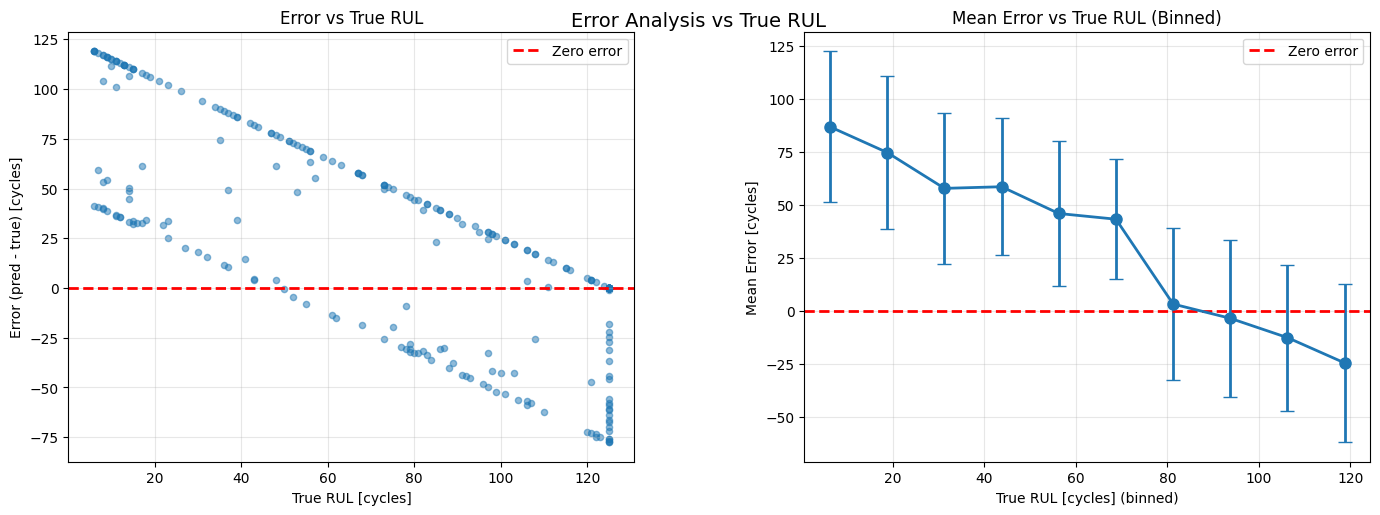

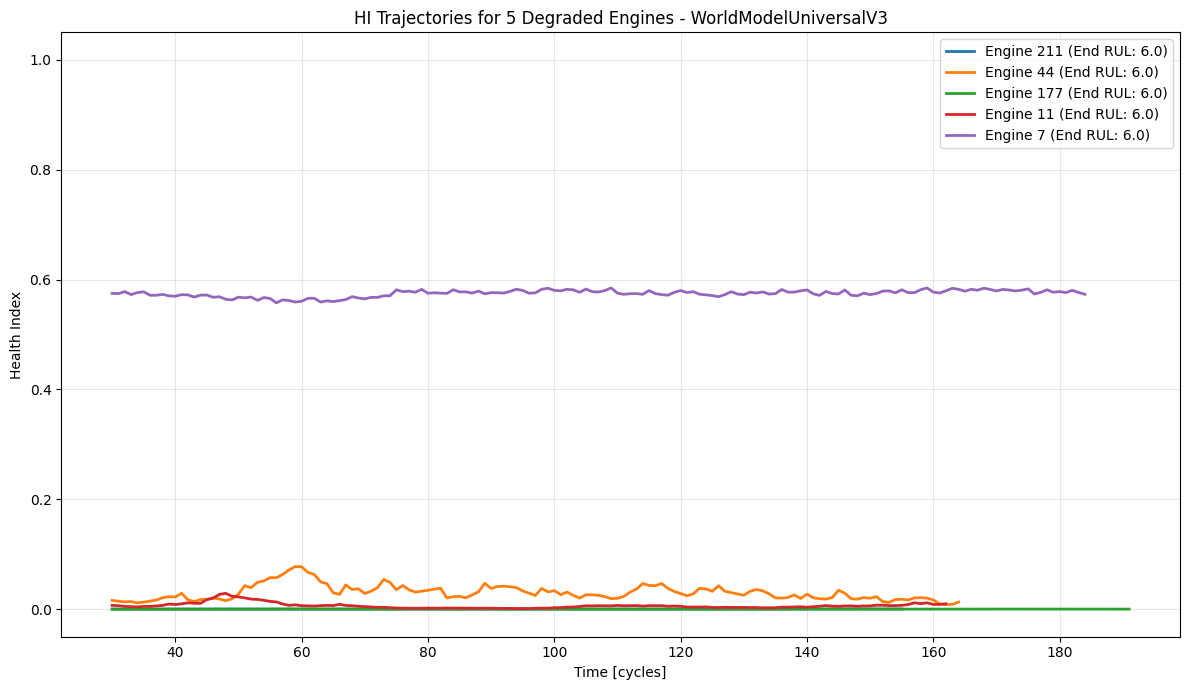

✅ HI trajectories plotted


In [10]:
# Ensure interactive plotting is enabled
import matplotlib
matplotlib.use('module://matplotlib_inline.backend_inline')
import matplotlib.pyplot as plt

# 5. HI Trajectories for Degraded Engines
print("=" * 80)
print("HI Trajectories for 5 Degraded Engines")
print("=" * 80)

from src.analysis.diagnostics import compute_hi_trajectory_sliding
from IPython import get_ipython
# diagnostics.py sets Agg; reset to inline after import
get_ipython().run_line_magic("matplotlib", "inline")
import matplotlib.pyplot as plt

# Determine model type flags for the function
model_type_name = type(model).__name__
is_wm_v3 = (model_type_name == "WorldModelUniversalV3")
# Both V2 and V3 are world models in this context
is_wm = True 

# Select 5 engines with lowest RUL at EOL (most degraded/closest to failure)
# y_true_eol and unit_ids_test are aligned from Cell 6
sorted_idxs = np.argsort(y_true_eol)
degraded_unit_ids = [int(unit_ids_test[i]) for i in sorted_idxs[:5]]

print(f"Selected degraded engines: {degraded_unit_ids}")

plt.figure(figsize=(12, 7))

for unit_id in degraded_unit_ids:
    # Get data for this engine
    df_engine = df_test_fe[df_test_fe["UnitNumber"] == unit_id].sort_values("TimeInCycles")
    
    if len(df_engine) < past_len:
        print(f"Skipping engine {unit_id} (too short: {len(df_engine)} < {past_len})")
        continue
        
    # Compute HI trajectory
    cycles, hi_vals = compute_hi_trajectory_sliding(
        df_engine=df_engine,
        feature_cols=feature_cols,
        scaler_dict=scaler_dict,
        past_len=past_len,
        model=model,
        device=device,
        is_world_model=is_wm,
        is_world_model_v3=is_wm_v3,
        max_rul=max_rul
    )
    
    # Plot
    plt.plot(cycles, hi_vals, linewidth=2, label=f"Engine {unit_id} (End RUL: {y_true_eol[sorted_idxs[degraded_unit_ids.index(unit_id)]]:.1f})")

plt.xlabel("Time [cycles]")
plt.ylabel("Health Index")
plt.title(f"HI Trajectories for 5 Degraded Engines - {model_type_name}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim([-0.05, 1.05])  # HI is usually [0, 1]
plt.tight_layout()
from IPython.display import display
plt.show()

print("✅ HI trajectories plotted")
